# Import Libraries and Settings

In [1]:
import cv2
import os
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from PIL import Image


In [2]:
random.seed(42)

# Load Data

In [3]:
def load_images(folder_path):
    print(f'fetching images for label {folder_path}...')

    image_dict = {}

    for filename in os.listdir(folder_path):
        
        # Skip files with the .csv extension
        if filename.endswith('.csv'):
            continue

        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            image_dict[filename] = img

    return image_dict

In [4]:
def load_annotations(root_path):
    print(f'fetching annotations for label {root_path}...')

    csv_path = os.path.join(root_path, "annotations.csv")
    df = pd.read_csv(csv_path)
    
    return df

In [5]:
# declare folder paths
# 1. folders should be at the root
# 2. folder name should be the class name as well
FOLDER_PATHS = [
    'Apple',
    'Banana',
]

In [6]:
data_dict = {}

for path in FOLDER_PATHS:
    data_dict[path] = {}
    data_dict[path]['images'] = load_images(path)
    data_dict[path]['annotations'] = load_annotations(path)

    print('...')

fetching images for label Apple...
fetching annotations for label Apple...
...
fetching images for label Banana...
fetching annotations for label Banana...
...


# View Samples + Bounding Boxes (Before Cleaning)

In [7]:
NUM_SAMPLES = 5

In [8]:

def visualize_random_samples(annotations_df, images_dict, num_samples=5):

    # Select random images from the list of filenames
    image_filenames = list(images_dict.keys())
    random_images = random.sample(image_filenames, num_samples)
    
    for filename in random_images:

        # Retrieve image from the dictionary
        image = images_dict.get(filename)
        if image is None:
            print(f"Image {filename} not found.")
            continue
        
        # Retrieve annotations for the current image
        image_annotations = annotations_df[annotations_df['filename'] == filename]
        
        fig, ax = plt.subplots()
        ax.imshow(image)
        
        # Add bounding box(es) to the image
        for index, annotation in image_annotations.iterrows():
            rect = patches.Rectangle((annotation['xmin'], annotation['ymin']),
                                     annotation['xmax'] - annotation['xmin'],
                                     annotation['ymax'] - annotation['ymin'],
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        
        ax.set_title('Sample Image with Bounding Box')
        plt.show()

Showing samples for label Apple...


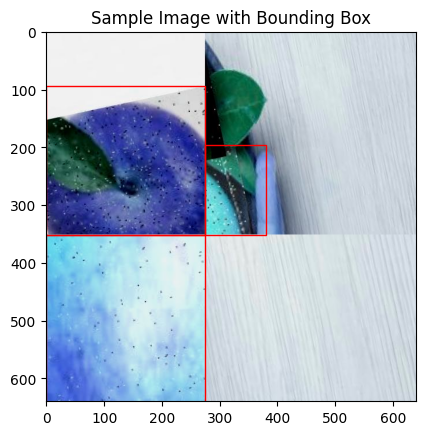

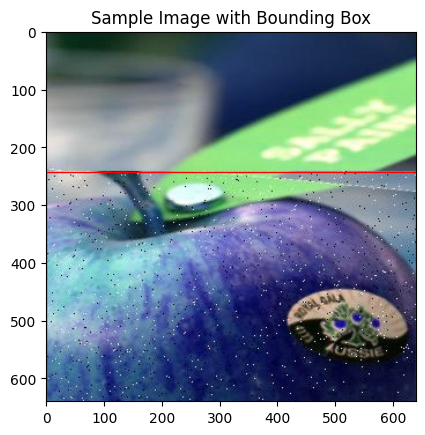

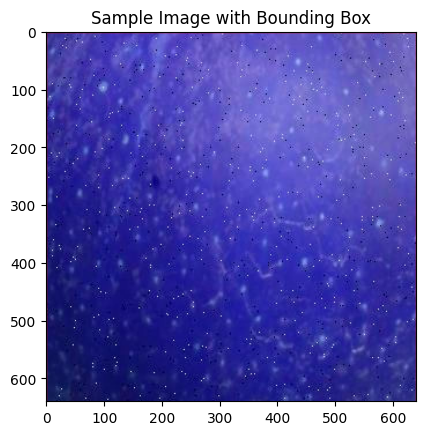

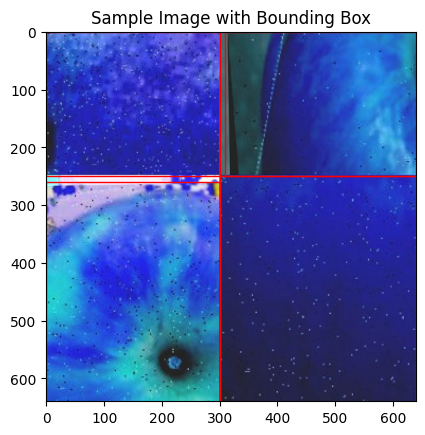

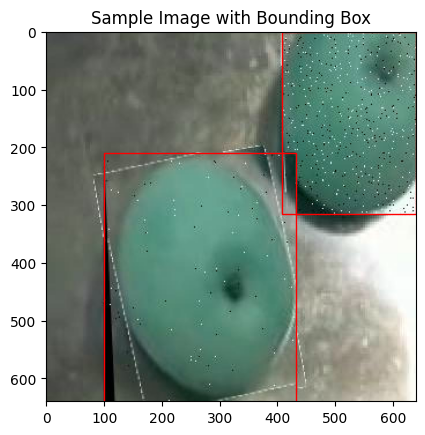

filename  width  height  \
0  istockphoto-184276818-612x612_jpg.rf.005b6c193...    640     640   
1  istockphoto-184276818-612x612_jpg.rf.005b6c193...    640     640   
2  istockphoto-184276818-612x612_jpg.rf.005b6c193...    640     640   
3  Apple_Tray_59_jpg.rf.0049dcbcf4c126b246d027b39...    640     640   
4  Apple_Tray_59_jpg.rf.0049dcbcf4c126b246d027b39...    640     640   

                           class  xmin  ymin  xmax  ymax  
0                              -     0     0   390   300  
1  Apples - v3 2023-01-16 1-40pm   251   300   390   640  
2  Apples - v3 2023-01-16 1-40pm   390   300   640   640  
3  Apples - v3 2023-01-16 1-40pm   506     0   640   174  
4  Apples - v3 2023-01-16 1-40pm    30     0   316   314

Showing samples for label Banana...


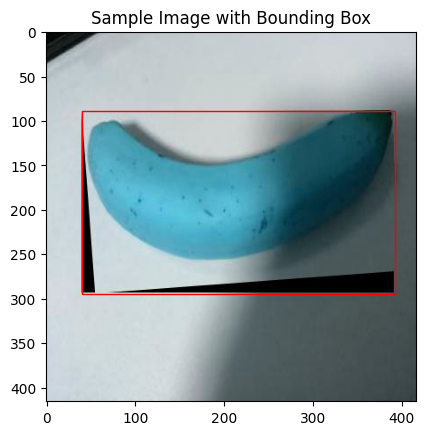

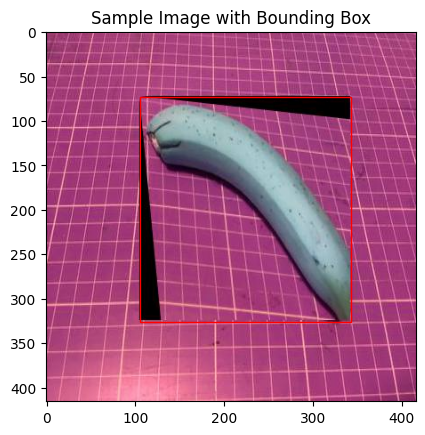

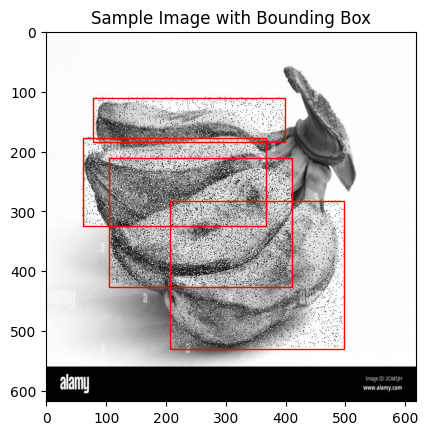

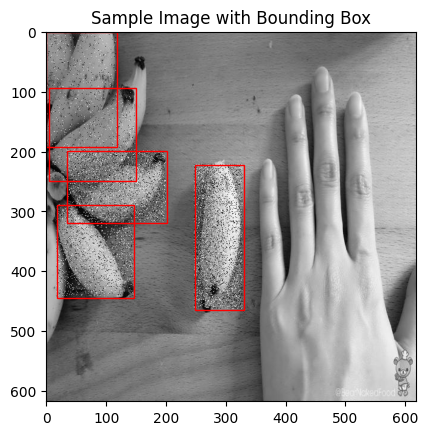

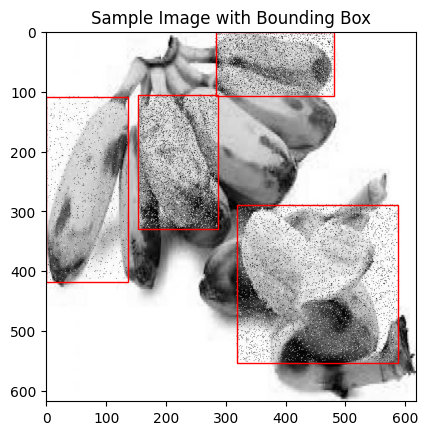

filename  width  height  \
0  IMG_0712_resized_jpg.rf.8c6b4b9c4be1d27e20b811...    416     416   
1  IMG_0713_resized_jpg.rf.1b191d9155bbae7cf79576...    416     416   
2  IMG_0711_resized_jpg.rf.3ec104a890536f12e5df6c...    416     416   
3  IMG_0715_resized_jpg.rf.2fa3e08bfc71fbed4062cb...    416     416   
4  IMG_0712_resized_jpg.rf.7b1020c2110f8c0204c147...    416     416   

            class  xmin  ymin  xmax  ymax  
0  bananarotation    21   135   350   293  
1  bananarotation    26    83   377   244  
2  bananarotation   187    58   337   364  
3  bananarotation    73    73   326   311  
4  bananarotation    21   135   350   293

In [9]:
for path in FOLDER_PATHS:
  print(f'Showing samples for label {path}...')
  visualize_random_samples(data_dict[path]['annotations'], data_dict[path]['images'], num_samples=NUM_SAMPLES)
  display(data_dict[path]['annotations'].head())

# Format Dataset

## Rename Image Filenames & Annotations Filenames

In [10]:
def rename_files(og_dict):

  data_dict = og_dict.copy()

  for label, data in data_dict.items():
    images_dict = data["images"]
    annotations_df = data["annotations"]

    # create rename map
    rename_map = {}
    idx = 0
    for filename in images_dict.keys():
        rename_map[filename] =  label + "_" + str(idx)
        idx += 1
    
    # Rename image filenames and update dictionary
    new_images = {}
    for old_filename, image in images_dict.items():
      new_filename = rename_map.get(old_filename)
      if new_filename:
        new_images[new_filename] = image
      else:
        print(f"Warning: Filename {old_filename} not found in rename map")
    data["images"] = new_images
    
    # Rename filenames in annotations_df dataframe
    annotations_df["filename"] = annotations_df["filename"].apply(lambda x: rename_map.get(x, x))

    # Sort annotations by filename
    data_dict[label]['annotations'] = annotations_df.sort_values(by='filename')

  return data_dict


In [11]:
clean_data_dict = rename_files(data_dict)

## Rename Annotations Classes

In [12]:
def rename_class(og_dict):

    data_dict = og_dict.copy()

    for label, data in data_dict.items():
        annotations_df = data["annotations"]
        annotations_df['class'] = label

    return data_dict

In [13]:
clean_data_dict = rename_class(clean_data_dict)

# View Samples + Bounding Boxes (After Cleaning)

Showing samples for label Apple...


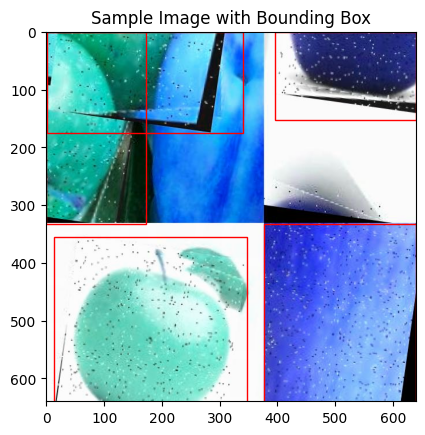

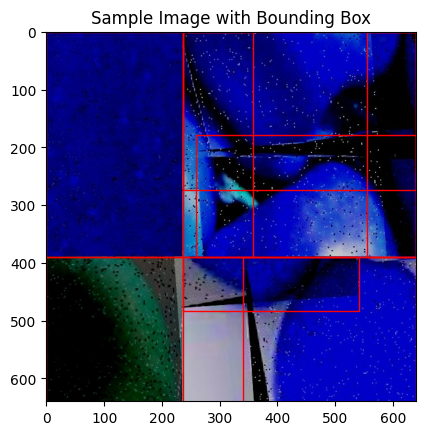

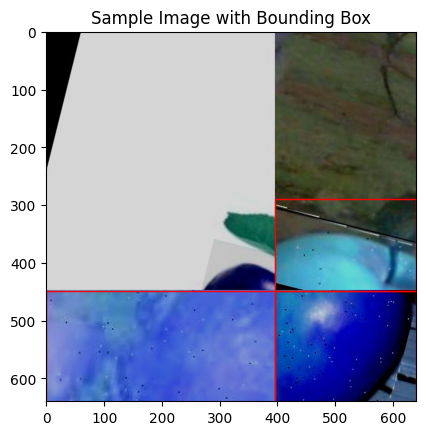

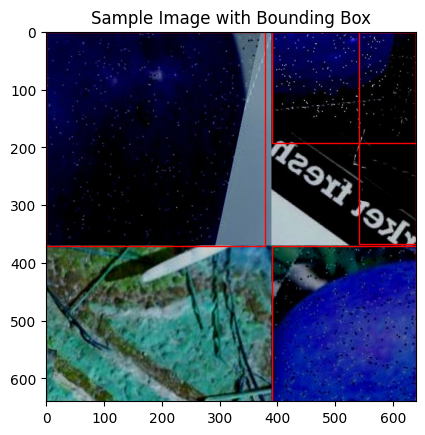

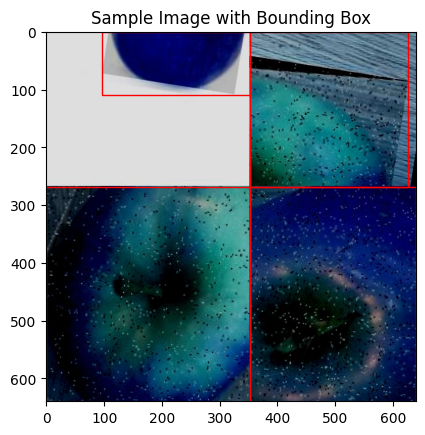

filename  width  height  class  xmin  ymin  xmax  ymax
0  Apple_3222    640     640  Apple     0     0   390   300
1  Apple_3222    640     640  Apple   251   300   390   640
2  Apple_3222    640     640  Apple   390   300   640   640
3  Apple_1792    640     640  Apple   506     0   640   174
4  Apple_1792    640     640  Apple    30     0   316   314

Showing samples for label Banana...


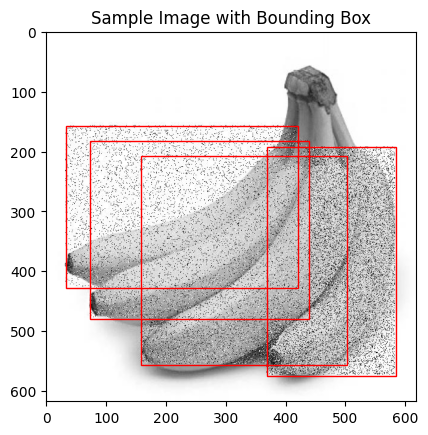

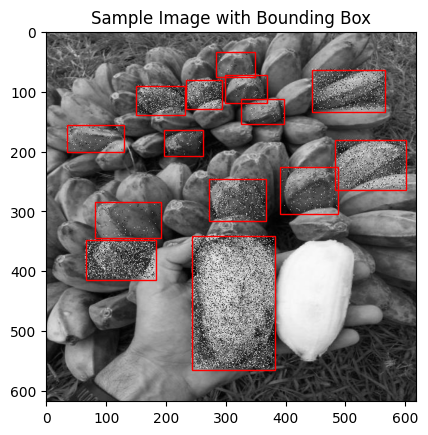

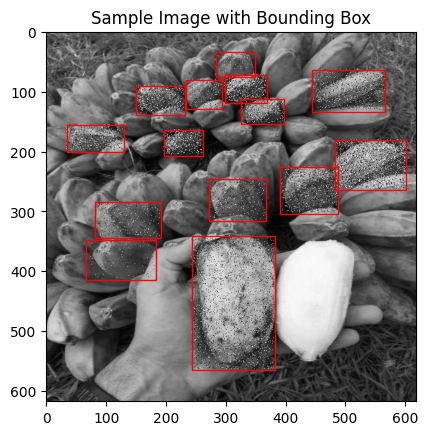

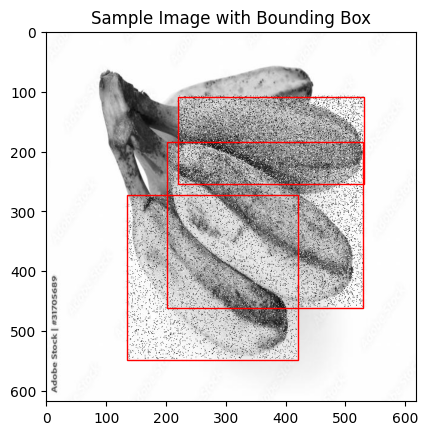

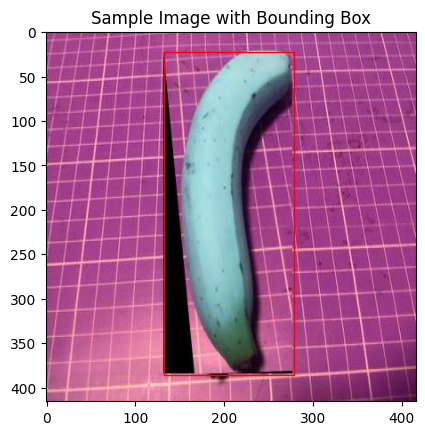

filename  width  height   class  xmin  ymin  xmax  ymax
0  Banana_49    416     416  Banana    21   135   350   293
1  Banana_51    416     416  Banana    26    83   377   244
2  Banana_45    416     416  Banana   187    58   337   364
3  Banana_56    416     416  Banana    73    73   326   311
4  Banana_48    416     416  Banana    21   135   350   293

In [14]:
for path in FOLDER_PATHS:
  print(f'Showing samples for label {path}...')
  visualize_random_samples(clean_data_dict[path]['annotations'], clean_data_dict[path]['images'], num_samples=NUM_SAMPLES)
  display(clean_data_dict[path]['annotations'].head())

# Export Tidy Data

In [15]:
def export_dict_as_folder(my_dict):

    for label, data in my_dict.items():

        # create label folder
        cleaned_data_dir = "cleaned_data"
        if not os.path.exists(cleaned_data_dir):
            os.makedirs(cleaned_data_dir)

        save_dir = f'cleaned_data/{label}'
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)

        # Save annotations to CSV
        annotations_df = data['annotations']
        csv_path = os.path.join(save_dir, f"{label}_annotations.csv")
        annotations_df.to_csv(csv_path, index=False) 

        # export images into label folder with approriate names
        image_dict = data['images']
        for filename, img in image_dict.items():
            if img is not None:
                
                # Convert to RGB if necessary (assuming BGR by default)
                if cv2.cvtColor(img, 0).ndim == 3:
                    img_rgb = img
                else:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Save as PNG
                output_path = os.path.join(save_dir, os.path.splitext(filename)[0] + ".png")
                cv2.imwrite(output_path, img_rgb)



In [16]:
export_dict_as_folder(clean_data_dict)